In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
plt.rc('figure', figsize=(16.0, 4.0))

In [2]:
import librosa
signal, samplerate = librosa.load("/home/mars/musictoys/boat.wav", sr=44100)
onset_env = librosa.onset.onset_strength(signal, sr=samplerate)                      
tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=samplerate) 
print tempo[0]    

120.185319767


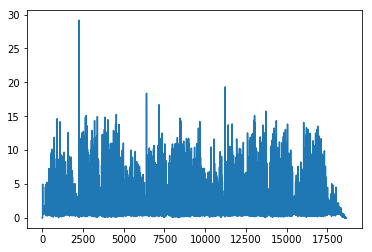

In [3]:
plt.plot(onset_env)

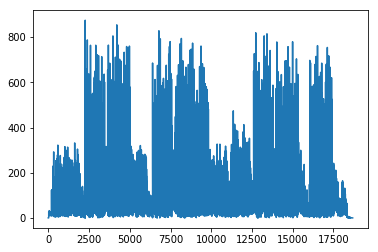

In [4]:
spectrogram = []
for offset in range(0, len(signal), 512):
    f = signal[offset:offset+512]
    spectrogram.append(np.abs(np.fft.rfft(f)))
flux = []
for i in range(len(spectrogram)-1):
    flux.append(np.maximum(spectrogram[i+1] - spectrogram[i], 0))
onset_strength = np.zeros(len(flux), np.float)
for i, frame in enumerate(flux):
    onset_strength[i] = np.sum(frame)
plt.plot(onset_strength)

In [5]:
tempo = librosa.beat.tempo(onset_envelope=onset_strength, sr=samplerate, hop_length=512) 
print tempo[0]    

120.185319767


In [6]:
from time import time
class logtime:
    def __init__(self, msg):
        self.msg = msg
    def __enter__(self):
        print "beginning %s" % self.msg
        self.start = time()
    def __exit__(self, type, value, traceback):
        elapsed = time() - self.start
        print "%s time: %.2f" % (self.msg, elapsed)


In [50]:
def tempo_map(envelope, frame_rate):
    # Look for patterns of activations in this envelope signal which are
    # likely to correlate with the musical tempo.
    # We will use an 8-second autocorrelation window so we can still
    # capture a significant number of low-tempo beat events. This must be
    # rounded to an even number of envelope frames.
    window_size = int(8.0 * frame_rate)
    window_mask = np.hanning(window_size)
    # Our model holds that the average tempo is 120 BPM, and that tempos
    # follow a log-normal distribution around that mean.
    bpm_mean, bpm_std = 120.0, 1.0
    bpms = np.empty(window_size, dtype=np.float)
    bpms[0] = np.inf
    bpms[1:] = frame_rate / np.arange(1.0, window_size) * 60.0
    weight = np.exp(-0.5 * ((np.log2(bpms) - np.log2(bpm_mean)) / bpm_std)**2)
    # Divide the signal into evenly sized windows; autocorrelate each one,
    # accumulating the amplitudes into a histogram of tempo probabilities.
    tempogram = np.zeros(window_size, np.float)
    n_frames = 1 + len(envelope) - window_size
    for i in range(n_frames):
        frame = envelope[i:i + window_size] * window_mask
        corr = np.correlate(frame, frame, mode='full')
        corr = corr[corr.size / 2:]
        tempogram += corr / np.max(np.abs(corr))
    tempogram /= float(n_frames)
    # Weight the frequency peaks by the probability distribution, then select
    # the best remaining candidate. The corresponding BPM value is our result.
    return bpms[np.argmax(tempogram * weight)]


tempo = tempo_map(onset_strength, float(samplerate) / 512.0) 
print tempo 

120.185319767


In [44]:
def interval_histogram(activations, min_tau=1, max_tau=None):
    # set the maximum delay
    if max_tau is None:
        max_tau = len(activations) - min_tau
    # test all possible delays
    taus = list(range(min_tau, max_tau + 1))
    bins = []
    # Note: this is faster than:
    #   corr = np.correlate(activations, activations, mode='full')
    #   bins = corr[len(activations) + min_tau - 1: len(activations) + max_tau]
    for tau in taus:
        bins.append(np.sum(np.abs(activations[tau:] * activations[0:-tau])))
    # return histogram
    return np.array(bins), np.array(taus)

In [9]:
tempogram = interval_histogram(onset_env / onset_env.max())
print tempogram[0].shape
print tempogram[1][np.argmax(tempogram[0])]

(18680,)
43


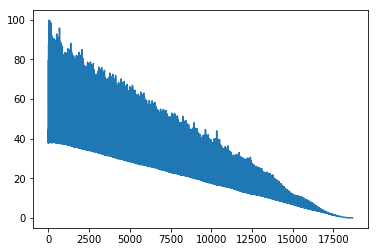

In [10]:
plt.plot(tempogram[0])

In [11]:
NO_TEMPO = 0
def detect_tempo(histogram, fps):
    """
    Extract the tempo from the given histogram.
    Parameters
    ----------
    histogram : tuple
        Histogram (tuple of 2 numpy arrays, the first giving the strengths of
        the bins and the second corresponding delay values).
    fps : float
        Frames per second.
    Returns
    -------
    tempi : numpy array
        Numpy array with the dominant tempi [bpm] (first column) and their
        relative strengths (second column).
    """
    #from scipy.signal import argrelmax
    # histogram of IBIs
    bins = histogram[0]
    # convert the histogram bin delays to tempi in beats per minute
    tempi = 60.0 * fps / histogram[1]
    # to get the two dominant tempi, just keep the peaks
    # use 'wrap' mode to also get peaks at the borders
    #peaks = argrelmax(bins, mode='wrap')[0]
    peaks = [np.argmax(tempi)]
    # we need more than 1 peak to report multiple tempi
    if len(peaks) == 0:
        # a flat histogram has no peaks, use the center bin
        if len(bins):
            ret = np.asarray([tempi[len(bins) // 2], 1.])
        else:
            # otherwise: no peaks, no tempo
            ret = np.asarray([NO_TEMPO, 0.])
    elif len(peaks) == 1:
        # report only the strongest tempo
        ret = np.asarray([tempi[peaks[0]], 1.])
    else:
        # sort the peaks in descending order of bin heights
        sorted_peaks = peaks[np.argsort(bins[peaks])[::-1]]
        # normalize their strengths
        strengths = bins[sorted_peaks]
        strengths /= np.sum(strengths)
        # return the tempi and their normalized strengths
        ret = np.asarray(list(zip(tempi[sorted_peaks], strengths)))
    # return the tempi
    return np.atleast_2d(ret)


In [12]:
print len(onset_env), len(y), sr
step_size = int(round(len(y) / len(onset_env)))
fps = float(sr) / 512
print fps, step_size
tempi = detect_tempo(tempogram, fps)
print tempi

18681

NameError: name 'y' is not defined

In [ ]:
tempo_in_frames = tempogram[1][np.argmax(tempogram[0])]
tempo_in_samples = tempo_in_frames * 512
print tempo_in_samples
beats_per_second = float(tempo_in_samples) / sr
print beats_per_second
beats_per_minute = beats_per_second * 60
print beats_per_minute